# 따릉이 대여수 예측

## 라이브러리 호출

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config inlineBackend.figure_format = 'retina' #선명하게 만들기

#한글폰트 가져오기
from matplotlib import rc
rc('font', family='NanumGothic')

# Warning 메세지를 뜨지 않게 해줌
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_squared_error , r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


## 데이터 불러오기

In [2]:
train = pd.read_csv('./data/SeoulBikeData_train.csv')
test = pd.read_csv('./data/SeoulBikeData_test.csv')

train_origin = train.copy()
test_origin = test.copy()

In [3]:
print(train.columns)
print(test.columns)
train.shape, test.shape

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(째C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(째C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')
Index(['Date', 'Hour', 'Temperature(째C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(째C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


((8040, 14), (720, 13))

In [4]:
train.rename(columns={'Temperature(째C)':'Temperature(°C)','Dew point temperature(째C)':'Dew point temperature(°C)'},inplace=True)
test.rename(columns={'Temperature(째C)':'Temperature(°C)','Dew point temperature(째C)':'Dew point temperature(°C)'},inplace=True)

### 기본정보 확인

#### head, tail, info, describe 확인

In [5]:
train.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,NaN,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,NaN,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
train.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8035,31/10/2018,1507,19,8.4,53,NaN,2000,-0.6,0.0,0.0,0.0,Autumn,No Holiday,Yes
8036,31/10/2018,1176,20,7.6,59,0.7,2000,0.0,0.0,0.0,0.0,NaN,No Holiday,Yes
8037,31/10/2018,1069,21,7.6,59,3.0,1929,0.0,0.0,0.0,0.0,Autumn,No Holiday,Yes
8038,31/10/2018,1088,22,6.8,58,2.2,1936,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8039,31/10/2018,798,23,6.4,60,1.8,1930,-0.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [7]:
train.info()
train.Date = pd.to_datetime(train.Date,format='%d/%m/%Y')
test.Date = pd.to_datetime(test.Date,format='%d/%m/%Y')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8040 non-null   object 
 1   Rented Bike Count          8040 non-null   int64  
 2   Hour                       8040 non-null   int64  
 3   Temperature(°C)            7240 non-null   float64
 4   Humidity(%)                8040 non-null   int64  
 5   Wind speed (m/s)           7238 non-null   float64
 6   Visibility (10m)           8040 non-null   int64  
 7   Dew point temperature(°C)  8040 non-null   float64
 8   Solar Radiation (MJ/m2)    8040 non-null   float64
 9   Rainfall(mm)               8040 non-null   float64
 10  Snowfall (cm)              8040 non-null   float64
 11  Seasons                    7238 non-null   object 
 12  Holiday                    8040 non-null   object 
 13  Functioning Day            8040 non-null   objec

In [8]:
train.describe()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8040,8040.000000,8040.000000,7240.000000,8040.000000,7238.000000,8040.000000,8040.000000,8040.000000,8040.000000,8040.000000
mean,2018-05-17 00:00:00,709.775995,11.500000,13.498564,58.271020,1.756756,1459.170896,4.522239,0.587072,0.152164,0.066493
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2018-02-22 00:00:00,191.000000,5.750000,3.500000,43.000000,1.000000,977.000000,-4.600000,0.000000,0.000000,0.000000
50%,2018-05-17 00:00:00,485.000000,11.500000,15.600000,57.000000,1.600000,1741.000000,6.400000,0.020000,0.000000,0.000000
75%,2018-08-09 00:00:00,1080.500000,17.250000,23.300000,74.000000,2.400000,2000.000000,15.600000,0.960000,0.000000,0.000000
max,2018-10-31 00:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000
std,NaN,657.320605,6.922617,12.270471,20.340492,1.045901,603.716284,13.393517,0.886186,1.127026,0.378182


#### 결측치 확인

In [9]:
print(train.isna().sum())
test.isna().sum()

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)              800
Humidity(%)                    0
Wind speed (m/s)             802
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      802
Holiday                        0
Functioning Day                0
dtype: int64


Date                          0
Hour                          0
Temperature(°C)              76
Humidity(%)                   0
Wind speed (m/s)             74
Visibility (10m)              0
Dew point temperature(°C)     0
Solar Radiation (MJ/m2)       0
Rainfall(mm)                  0
Snowfall (cm)                 0
Seasons                      74
Holiday                       0
Functioning Day               0
dtype: int64

## 1차 전처리
기본적인 변수파악은 이전 과제로 대체

### 결측치 처리

#### Seasons
전후 행의 Seasons를 확인하고 둘이 같으면 그 값으로 대체, 그렇지 않으면 결측치 그대로

In [10]:
train['Seasons'] = np.where(train['Seasons'].ffill() == train['Seasons'].bfill(), train['Seasons'].ffill(), np.nan)
print('train 데이터셋 Seasons열에 남은 결측치 수: ',train['Seasons'].isna().sum(),'\n결측치가 존재하는 행')
display(train[train['Seasons'].isna()])

test['Seasons'] = np.where(test['Seasons'].ffill() == test['Seasons'].bfill(), test['Seasons'].ffill(), np.nan)
print('test 데이터셋 Seasons열에 남은 결측치 수: ',test['Seasons'].isna().sum(),'\n결측치가 존재하는 행')
display(test[test['Seasons'].isna()])

train 데이터셋 Seasons열에 남은 결측치 수:  1 
결측치가 존재하는 행


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,NaN,No Holiday,Yes


test 데이터셋 Seasons열에 남은 결측치 수:  0 
결측치가 존재하는 행


,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day


In [11]:
#남은 결측치가 첫행인 것을 확인하고 같은날인 다음행 값으로 대체함
train['Seasons'][0] = train['Seasons'][1]
print('train 데이터셋 Seasons열에 남은 결측치 수: ', train['Seasons'].isna().sum())

train 데이터셋 Seasons열에 남은 결측치 수:  0


#### Temperature(°C)
시간에 따른 변동성이 적다는 것을 고려해 전,후 값의 평균으로 대체 

In [12]:
train['Temperature(°C)'] = train['Temperature(°C)'].fillna((train['Temperature(°C)'].shift() + train['Temperature(°C)'].shift(-1)) / 2)
print('train 데이터셋 Temperature열에 남은 결측치 수: ', train['Temperature(°C)'].isna().sum())

test['Temperature(°C)'] = test['Temperature(°C)'].fillna((test['Temperature(°C)'].shift() + test['Temperature(°C)'].shift(-1)) / 2)
print('test 데이터셋 Temperature열에 남은 결측치 수: ', test['Temperature(°C)'].isna().sum())

train 데이터셋 Temperature열에 남은 결측치 수:  156
test 데이터셋 Temperature열에 남은 결측치 수:  15


In [13]:
#연속해서 결측치인 행이 존재 -> rolling 메서드를 이용해 이동평균으로 남은 결측치 대체
window_size = 5
train['Temperature(°C)'] = train['Temperature(°C)'].fillna(train['Temperature(°C)'].rolling(window=window_size, min_periods=1, center=True).mean())
print('train 데이터셋 Temperature열에 남은 결측치 수: ', train['Temperature(°C)'].isna().sum())

test['Temperature(°C)'] = test['Temperature(°C)'].fillna(test['Temperature(°C)'].rolling(window=window_size, min_periods=1, center=True).mean())
print('test 데이터셋 Temperature열에 남은 결측치 수: ', test['Temperature(°C)'].isna().sum())

train 데이터셋 Temperature열에 남은 결측치 수:  0
test 데이터셋 Temperature열에 남은 결측치 수:  0


#### Wind speed (m/s)
시간에 따른 변동성이 큰편 -> 변화량의 분포를 따르는 난수를 생성후, 직전행에 더해 결측치 대체

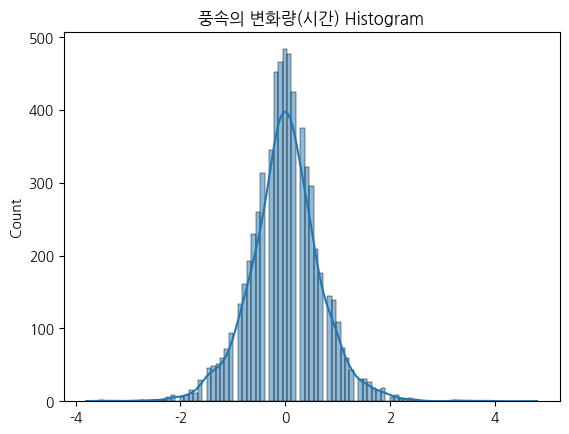

풍속 변화량의 평균: -0.001975800275693062 
풍속 변화량의 표준편차: 0.6820213252499085


In [14]:
wind_diff = []
wind_diff.append(np.nan) #첫행은 앞에 값이 없으므로 결측치 처리
for i in range(1, len(train)):
    diff = train['Wind speed (m/s)'][i] - train['Wind speed (m/s)'][i - 1]
    wind_diff.append(diff) 

sns.histplot(wind_diff, kde=True) #분포확인 -> 정규분포
plt.rcParams['axes.unicode_minus'] = False #축에 마이너스 표시
plt.title('풍속의 변화량(시간) Histogram')
plt.show()

print('풍속 변화량의 평균:',np.nanmean(wind_diff), '\n풍속 변화량의 표준편차:',np.nanstd(wind_diff))

In [15]:
wind_diff_mean = np.nanmean(wind_diff)
wind_diff_std = np.nanstd(wind_diff)

np.random.seed(100) #seed 설정
for i in range(1, len(train)):
    if pd.isna(train.loc[i, 'Wind speed (m/s)']):
        random_value = np.random.normal(loc=wind_diff_mean, scale=wind_diff_std, size=1)
        train.loc[i, 'Wind speed (m/s)'] = train.loc[i-1, 'Wind speed (m/s)'] + random_value
print('train 데이터셋 Wind speed (m/s)열에 남은 결측치 수: ', train['Wind speed (m/s)'].isna().sum())

#train데이터의 표본수가 월등히 많으므로, 풍속 변화량의 분포 그대로 이용
for i in range(1, len(test)):
    if pd.isna(test.loc[i, 'Wind speed (m/s)']):
        random_value = np.random.normal(loc=wind_diff_mean, scale=wind_diff_std, size=1)
        test.loc[i, 'Wind speed (m/s)'] = test.loc[i-1, 'Wind speed (m/s)'] + random_value
print('test 데이터셋 Wind speed (m/s)열에 남은 결측치 수: ', test['Wind speed (m/s)'].isna().sum())


train 데이터셋 Wind speed (m/s)열에 남은 결측치 수:  0
test 데이터셋 Wind speed (m/s)열에 남은 결측치 수:  0


### 파생변수 생성

#### 날짜
Date열의 정보를 year, month, day로 분류

In [16]:
train['year'] = train.Date.dt.year
train['month'] = train.Date.dt.month
train['day'] = train.Date.dt.day

test['year'] = test.Date.dt.year
test['month'] = test.Date.dt.month
test['day'] = test.Date.dt.day

#### 요일

In [17]:
train['Day_of_Week'] = train.Date.dt.day_name()
test['Day_of_Week'] = test.Date.dt.day_name()

#### Date변수 삭제
정보를 모두 변환한 Date변수는 Datetime형태이므로 모델 적용을 위해 삭제

In [18]:
train.drop('Date',axis=1,inplace=True)
test.drop('Date',axis=1,inplace=True)

#### 날씨
IQR을 기준으로 rain/Downpour, snow/Blizzard로 분류

강우량 IQR 시각화

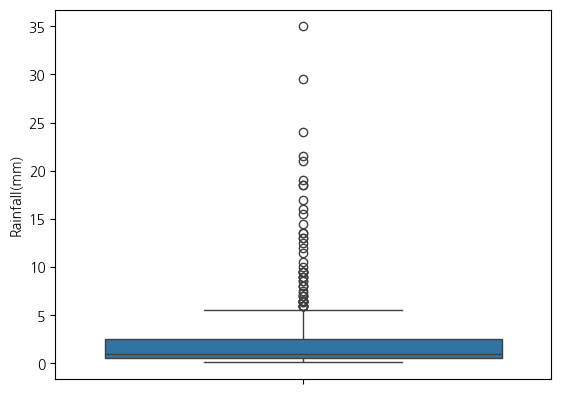

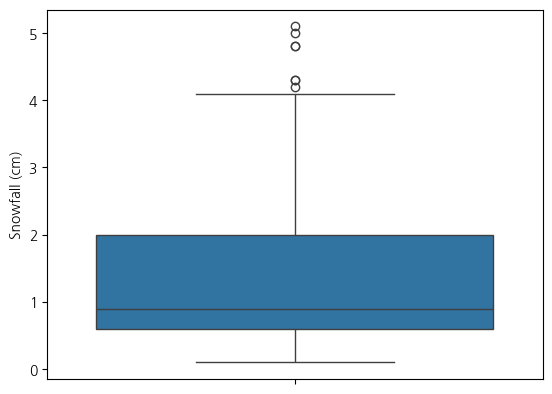

In [19]:
rain = train['Rainfall(mm)'][train['Rainfall(mm)']>0]
snow = train['Snowfall (cm)'][train['Snowfall (cm)']>0]

sns.boxplot(rain)
plt.show()
sns.boxplot(snow)
plt.show()

기준점 생성

In [20]:
Q1_rain = rain.quantile(0.25)
Q3_rain = rain.quantile(0.75)
IQR_rain = Q3_rain - Q1_rain
rain_upper_bound = Q3_rain + 1.5 * IQR_rain

Q1_snow = snow.quantile(0.25)
Q3_snow = snow.quantile(0.75)
IQR_snow = Q3_snow - Q1_snow
snow_upper_bound = Q3_snow + 1.5 * IQR_snow

weather변수 생성

In [21]:
train['Weather'] = 'Clear'
train.loc[(train['Rainfall(mm)'] > 0), 'Weather'] = 'Rain'
train.loc[(train['Snowfall (cm)'] > 0), 'Weather'] = 'Snow'
train.loc[(train['Rainfall(mm)'] > rain_upper_bound), 'Weather'] = 'Downpour'
train.loc[(train['Snowfall (cm)'] > snow_upper_bound), 'Weather'] = 'Blizzard'

test['Weather'] = 'Clear'
test.loc[(test['Rainfall(mm)'] > 0), 'Weather'] = 'Rain'
test.loc[(test['Snowfall (cm)'] > 0), 'Weather'] = 'Snow'
test.loc[(test['Rainfall(mm)'] > rain_upper_bound), 'Weather'] = 'Downpour'
test.loc[(test['Snowfall (cm)'] > snow_upper_bound), 'Weather'] = 'Blizzard'

print(train.Weather.value_counts())
print(test.Weather.value_counts())

Weather
Clear       7163
Rain         433
Snow         385
Downpour      52
Blizzard       7
Name: count, dtype: int64
Weather
Clear       654
Snow         45
Rain         11
Blizzard      6
Downpour      4
Name: count, dtype: int64


## EDA
모델링을 위한 EDA

### 종속변수 분포확인 

<Axes: xlabel='Rented Bike Count', ylabel='Count'>

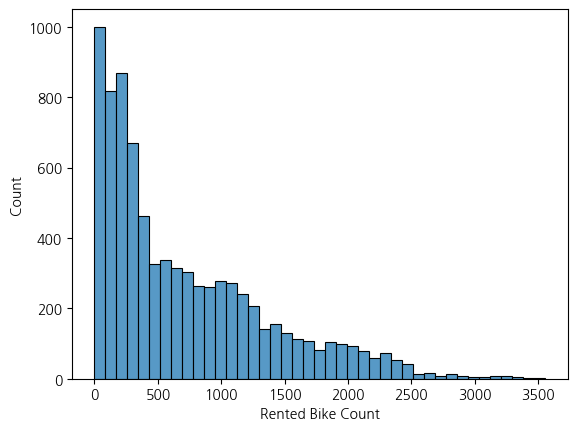

In [22]:
sns.histplot(train['Rented Bike Count']) #좌측으로 치우친 형태 -> 모델 적용할 때 로그변환 고려

### 독립변수 분포확인

##### 독립변수 간의 상관계수

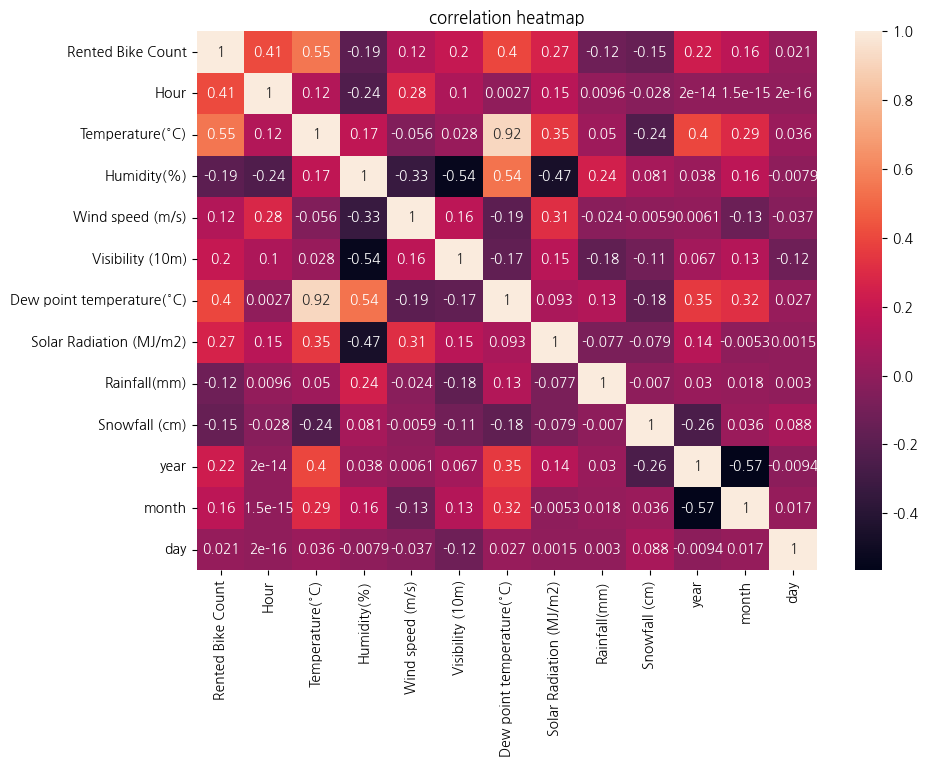

In [23]:
train_num = train.select_dtypes(include=[np.number])
plt.figure(figsize=(10,7))
sns.heatmap(train_num.corr(),annot = True)
plt.title('correlation heatmap')
plt.show()

높은애들만 추려서

Text(0.5, 1.0, 'correlation heatmap(abs(corr)>0.3)')

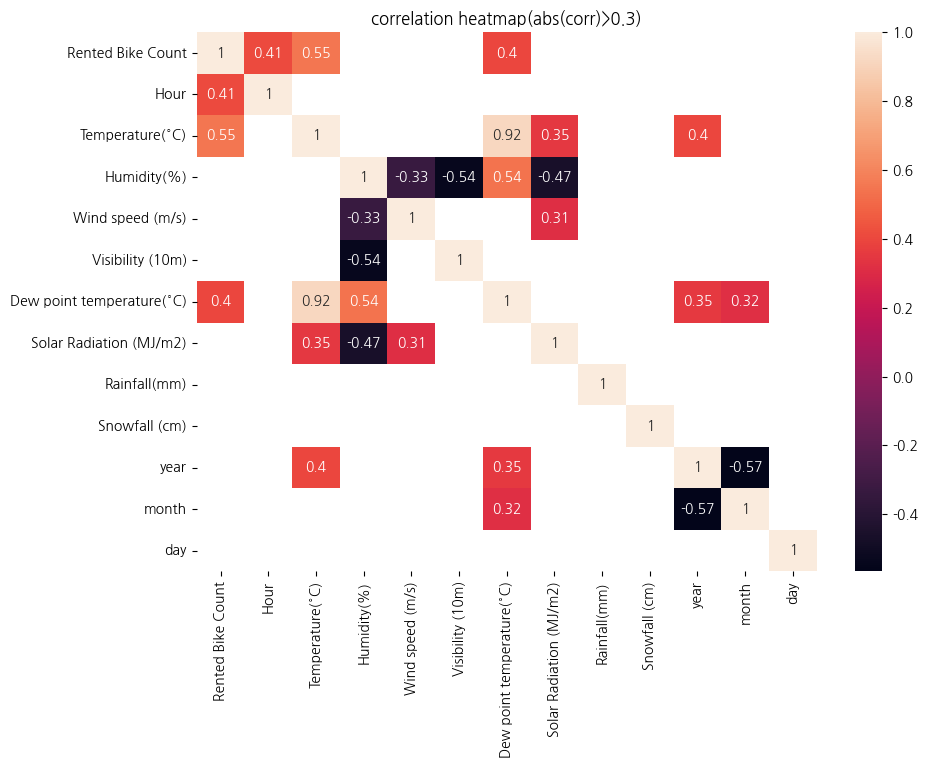

In [24]:
plt.figure(figsize=(10,7))
sns.heatmap(train_num.corr()[0.3<train_num.corr().abs()],annot = True)
plt.title('correlation heatmap(abs(corr)>0.3)')

#### 범주형 독립변수


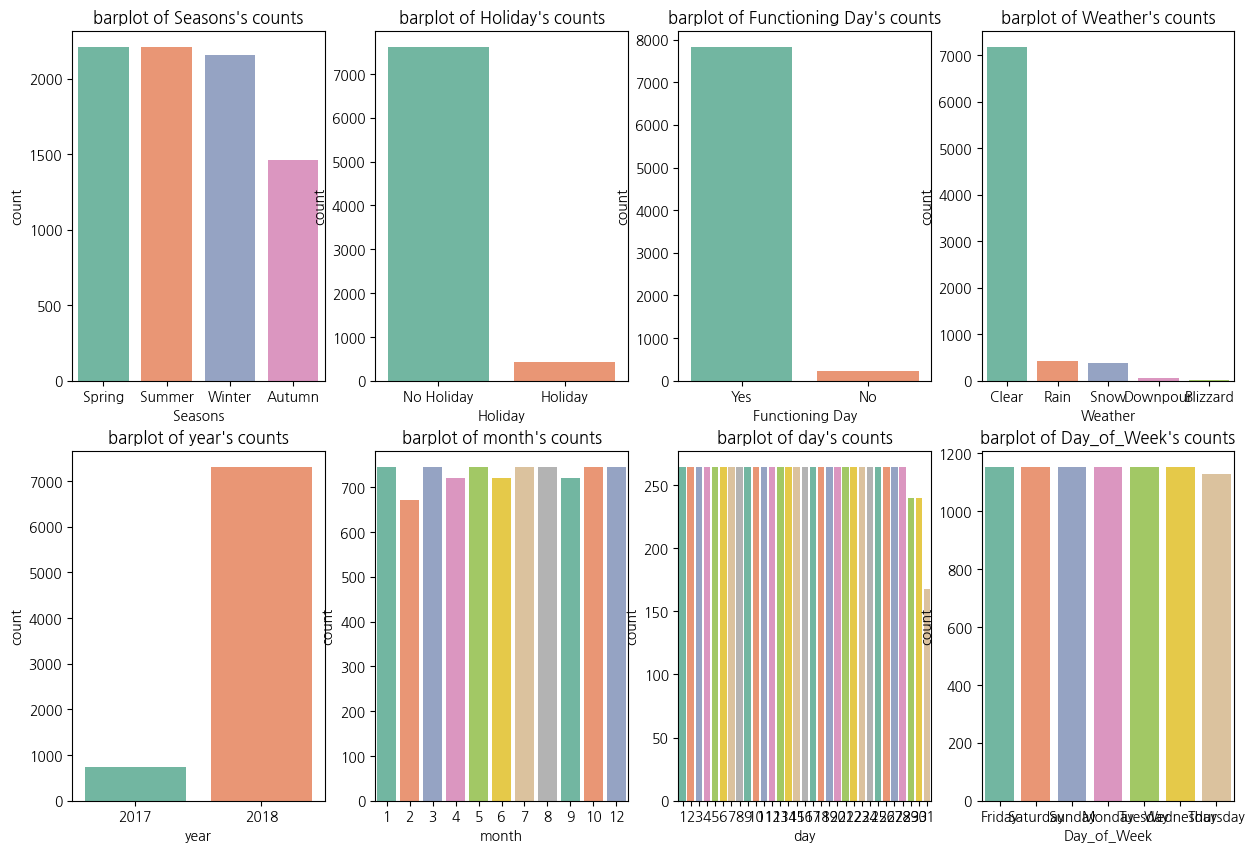

In [25]:
columns_categoty = ['Seasons', 'Holiday', 'Functioning Day','Weather','year','month','day','Day_of_Week']
plt.figure(figsize=(15, 10))
for column in columns_categoty:
    plt.subplot(2, 4, columns_categoty.index(column) + 1)
    sns.barplot(train[column].value_counts(), palette='Set2')
    plt.title(f'barplot of {column}\'s counts')

#### 수치형 독립변수

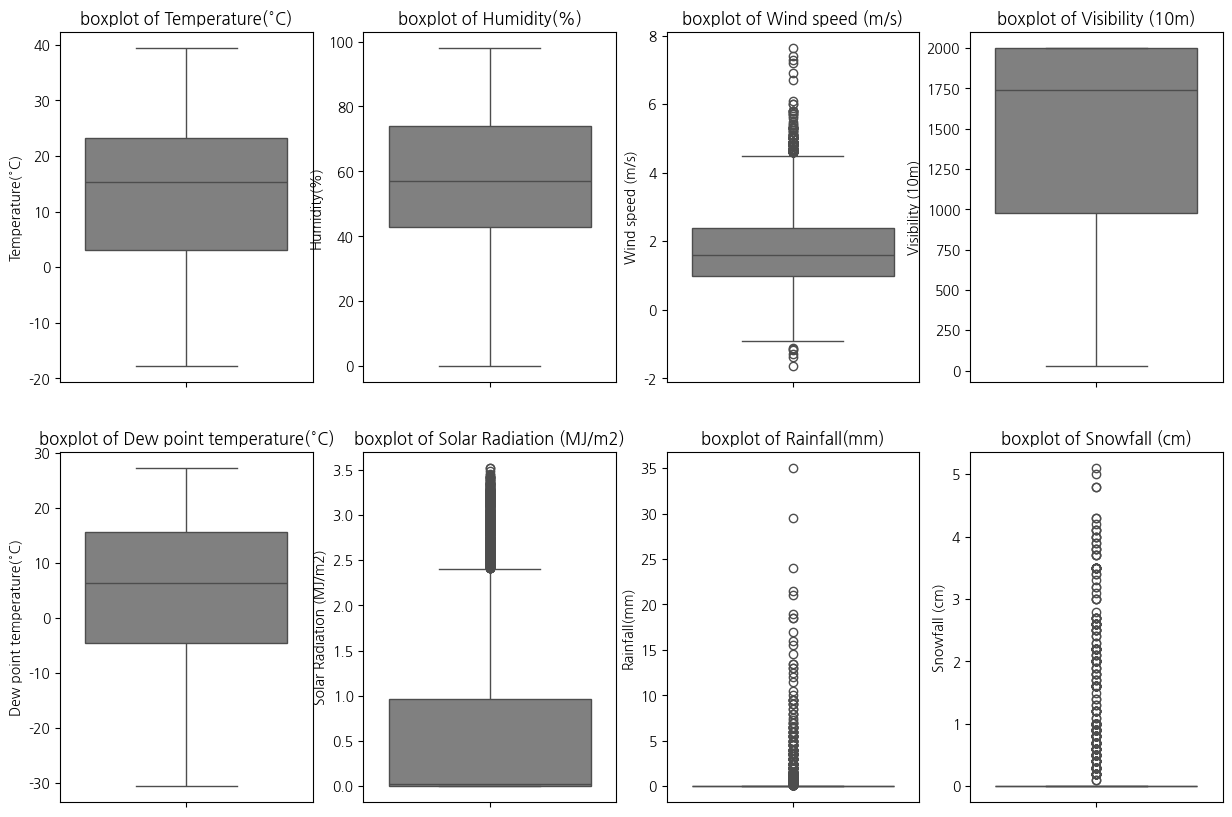

In [26]:
columns_numeric = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)','Rainfall(mm)', 'Snowfall (cm)']
plt.figure(figsize=(15, 10))
for column in columns_numeric:
    plt.subplot(2, 4, columns_numeric.index(column) + 1)
    sns.boxplot(y= train[column], color='gray')
    plt.title(f'boxplot of {column}')

### 독립변수와 종속변수의 관계

#### 종속변수와의 상관관계

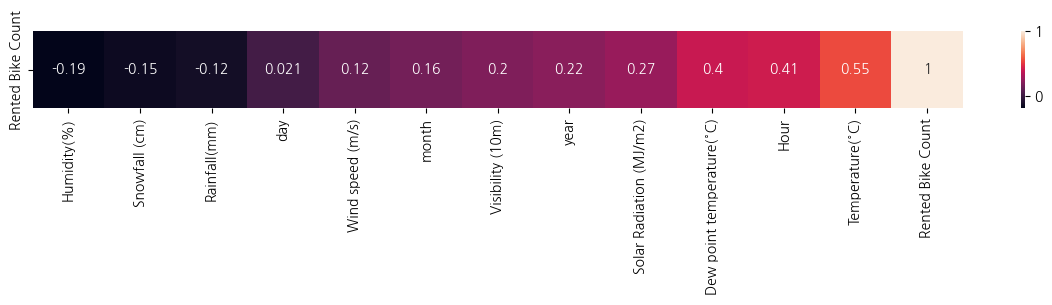

In [27]:
train_num = train.select_dtypes('number')
plt.figure(figsize=(15,1))
sns.heatmap(train_num.corr()['Rented Bike Count'].sort_values().to_frame().T, annot=True)
plt.show()

## 2차 전처리

### 범주형 변수 인코딩

In [28]:
columns_categoty
#Seasons, Weather, Day_of_Week는 원핫인코딩, Holiday,Functioning Day는 라벨 인코딩 적용

['Seasons',
 'Holiday',
 'Functioning Day',
 'Weather',
 'year',
 'month',
 'day',
 'Day_of_Week']

#### 원핫 인코딩
'Holiday','Functioning Day'는 라벨 인코딩을 할까했지만, Yes와 No중 어느쪽이 1이냐에 따라 영향력이 달라지므로 추후 삭제고려

In [29]:
ohe = OneHotEncoder(sparse=False)
result_ohe = ohe.fit_transform(train[['Seasons', 'Weather', 'Day_of_Week']])
df_ohe = pd.DataFrame(result_ohe,columns=ohe.get_feature_names_out(['Seasons', 'Weather', 'Day_of_Week']))
df_ohe

result_ohe_test = ohe.transform(test[['Seasons', 'Weather', 'Day_of_Week']])
df_ohe_test = pd.DataFrame(result_ohe_test,columns=ohe.get_feature_names_out(['Seasons', 'Weather', 'Day_of_Week']))
ohe.get_feature_names_out(['Seasons', 'Weather', 'Day_of_Week'])

array(['Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Weather_Blizzard', 'Weather_Clear',
       'Weather_Downpour', 'Weather_Rain', 'Weather_Snow',
       'Day_of_Week_Friday', 'Day_of_Week_Monday', 'Day_of_Week_Saturday',
       'Day_of_Week_Sunday', 'Day_of_Week_Thursday',
       'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday'], dtype=object)

In [30]:
#다중공선성 방지를 위해 하나씩 추가로 삭제
train = pd.concat([train, df_ohe],axis=1)
train.drop(['Seasons', 'Weather', 'Day_of_Week','Seasons_Autumn','Weather_Blizzard','Day_of_Week_Friday'],axis=1, inplace=True)

test = pd.concat([test, df_ohe_test],axis=1)
test.drop(['Seasons', 'Weather', 'Day_of_Week','Seasons_Autumn','Weather_Blizzard','Day_of_Week_Friday'],axis=1, inplace=True)

#### 라벨인코딩

In [31]:
train['Holiday'] = train['Holiday'].map({'Holiday':1,'No Holiday':0})
train['Functioning Day'] = train['Functioning Day'].map({'Yes':1,'No':0})

test['Holiday'] = test['Holiday'].map({'Holiday':1,'No Holiday':0})
test['Functioning Day'] = test['Functioning Day'].map({'Yes':1,'No':0})

### 1차 변수 선별
도메인 지식을 이용한 변수 선별
- 대여수와 연관이 적은 year, month, day 변수 삭제
- 이슬점 온도는 습도와 기온으로 결정되므로 이중으로 영향을 미치는 것을 방지하기 위해 Dew point temperature(°C) 변수 삭제
- 
- Rainfall(mm), Snowfall (cm)는 파생변수를 생성했지만, 회귀모델이므로 1차 모델링 후 결정

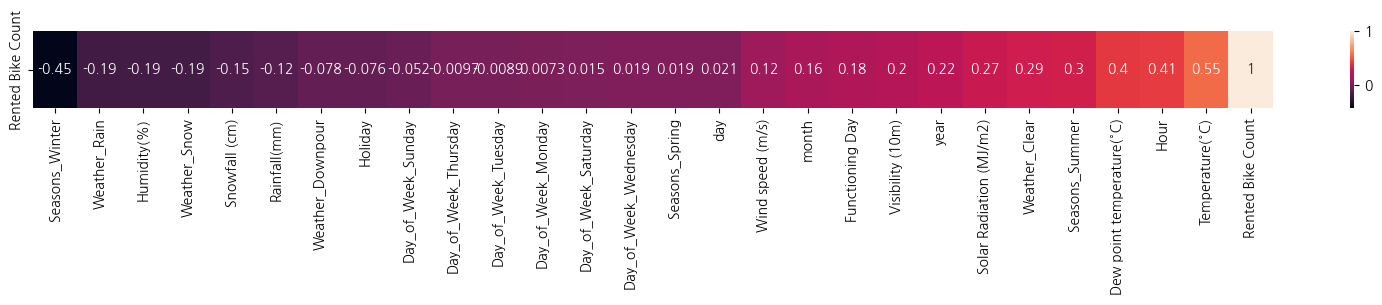

In [32]:
plt.figure(figsize=(20,1))
sns.heatmap(train.corr()['Rented Bike Count'].sort_values().to_frame().T, annot=True)
plt.show()

In [33]:
train.drop(['year','month','day','Dew point temperature(°C)'], axis=1, inplace=True)
test.drop(['year','month','day','Dew point temperature(°C)'], axis=1, inplace=True)

## 데이터 분리, 모델 선정
기존에 사용해봤던 선형회귀 모델로 진행, 데이터 분리(train데이터와 valid데이터로)
- 일반선형회귀: RSS를 최소화, 규제적용x
- 릿지(Ridge): L2규제 적용 -> (RSS + alpha * sum((W(회귀계수))^2))을 최소화 => 회귀 계수값의 크기 조정
- 라쏘(Lasso): L1규제 적용 -> (RSS + alpha * sum(abs(W(회귀계수))))를 최소화 => 영향력이 작은 회귀 계수값을 0으로 변환함(피처수 ↓)
- 엘라스틱넷(ElasticNet): L2,L1 규제 결합->  (RSS + alpha2 * sum((W(회귀계수))^2)+ alpha1 * sum(abs(W(회귀계수))))을 최소화 => L1을 통해 피처수를 줄이고, L2로 계수값의 크기를 조정

In [34]:
lr = LinearRegression()
ridge = Ridge() 
lasso = Lasso(random_state=1004) 
elastn = ElasticNet(random_state=1004)

X = train.drop('Rented Bike Count',axis=1)
y = train['Rented Bike Count']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

### 스케일링
변수 간의 단위가 다르기 때문에 스케일링 적용
<br>우선적으로 MinMax Scaler 적용, 최종모델 선정 후 스케일러 비교 진행

#### MinMax Scaler

In [35]:
mms = MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)
X_val_mms = mms.transform(X_val)

### 평가지표 출력함수 생성

In [36]:
# 평가지표 출력함수 생성
def eval(y_val, y_pred):
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

    print('MAE : {0:.3f}, RMSE : {1:.3F}'.format(mae, rmse))
    print('Variance score : {0:.3f}'.format(r2_score(y_val, y_pred)))


### 모델 비교

#### LinearRegression

In [37]:
print('\nMinMax Scaler')
lr.fit(X_train_mms,y_train)
y_pred = lr.predict(X_val_mms)
eval(y_val,y_pred)
print('회귀 계수값:', np.round(lr.coef_, 1))


MinMax Scaler
MAE : 315.018, RMSE : 413.100
Variance score : 0.595
회귀 계수값: [ 6.5990e+02  1.4223e+03 -6.8580e+02  2.2690e+02 -4.1000e+01 -2.9340e+02
 -6.9930e+02 -4.3600e+01 -1.1320e+02  1.0168e+03 -1.7910e+02 -1.8060e+02
 -4.6910e+02 -1.2700e+02 -5.6930e+02 -6.4510e+02 -2.3100e+01 -7.9200e+01
 -6.5900e+01 -1.4780e+02 -2.9100e+01 -3.7700e+01 -6.0000e-01]


#### Ridge

In [38]:
alphas = [0 , 0.1 , 1 , 3, 5, 10]

# alphas 값을 변화시켜가며 평가지표 계산
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train_mms,y_train)
    y_pred = ridge.predict(X_val_mms)
    print(f'alpha = {alpha}')
    eval(y_val,y_pred)

#alpha가 3정도일 때 가장 우수함

ridge = Ridge(alpha = 3)
ridge.fit(X_train_mms,y_train)
y_pred = ridge.predict(X_val_mms)
print('\nalpha = 3일 때의 회귀 계수값:\n', np.round(ridge.coef_, 1))

alpha = 0
MAE : 315.018, RMSE : 413.100
Variance score : 0.595
alpha = 0.1
MAE : 314.998, RMSE : 413.090
Variance score : 0.595
alpha = 1
MAE : 314.896, RMSE : 413.042
Variance score : 0.595
alpha = 3
MAE : 314.750, RMSE : 413.003
Variance score : 0.595
alpha = 5
MAE : 314.644, RMSE : 413.019
Variance score : 0.595
alpha = 10
MAE : 314.440, RMSE : 413.271
Variance score : 0.594

alpha = 3일 때의 회귀 계수값:
 [ 6.6390e+02  1.3414e+03 -6.6370e+02  2.1430e+02 -3.4500e+01 -2.6810e+02
 -3.6870e+02  4.8700e+01 -1.1020e+02  9.9420e+02 -1.7870e+02 -1.6410e+02
 -4.8310e+02  1.5440e+02 -3.7690e+02 -3.7620e+02  2.2320e+02 -7.6300e+01
 -6.3200e+01 -1.4560e+02 -2.8400e+01 -3.7300e+01  3.0000e-01]


#### Lasso

In [39]:
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
for alpha in lasso_alphas :
    lasso = Lasso(alpha = alpha, random_state=1004,)
    lasso.fit(X_train_mms,y_train)
    y_pred = lasso.predict(X_val_mms)
    print(f'alpha = {alpha}')
    eval(y_val,y_pred)

#alpha가 0.5일때 가장 우수, ridge보다 성능 우수
    
lasso = Lasso(alpha = 0.5, random_state=1004)
lasso.fit(X_train_mms,y_train)
y_pred = ridge.predict(X_val_mms)
print('\nalpha = 0.5일 때의 회귀 계수값:\n', np.round(lasso.coef_, 1))

alpha = 0.07
MAE : 314.835, RMSE : 412.999
Variance score : 0.595
alpha = 0.1
MAE : 314.760, RMSE : 412.964
Variance score : 0.595
alpha = 0.5
MAE : 313.951, RMSE : 412.649
Variance score : 0.596
alpha = 1
MAE : 313.293, RMSE : 412.654
Variance score : 0.595
alpha = 3
MAE : 314.458, RMSE : 416.398
Variance score : 0.588

alpha = 0.5일 때의 회귀 계수값:
 [ 664.1 1357.5 -636.6  167.9  -10.6 -247.6   -0.     0.  -100.6  989.2
 -161.8 -157.6 -457.8    0.  -606.6 -537.    71.7  -61.3  -47.  -130.9
  -12.8  -22.6    9. ]


#### ElasticNet

In [40]:
elastic_alphas = [ 0.01, 0.05, 0.1, 0.5, 1, 1.5, 3]
for alpha in elastic_alphas :
    elastn = ElasticNet(alpha=alpha, l1_ratio=1, random_state=1004)
    elastn.fit(X_train_mms,y_train)
    y_pred = elastn.predict(X_val_mms)
    print(f'alpha = {alpha}')
    eval(y_val,y_pred)
# alpha=0.5, l1_ratio=1일때 lasso와 같은 결과(같은 조건이기 때문에)

alpha = 0.01
MAE : 314.982, RMSE : 413.083
Variance score : 0.595
alpha = 0.05
MAE : 314.886, RMSE : 413.024
Variance score : 0.595
alpha = 0.1
MAE : 314.760, RMSE : 412.964
Variance score : 0.595
alpha = 0.5
MAE : 313.951, RMSE : 412.649
Variance score : 0.596
alpha = 1
MAE : 313.293, RMSE : 412.654
Variance score : 0.595
alpha = 1.5
MAE : 313.026, RMSE : 413.122
Variance score : 0.595
alpha = 3
MAE : 314.458, RMSE : 416.398
Variance score : 0.588


## 성능향상
성능이 가장 좋았던 alpha=0.5인 lasso모델로 확정 => 변수 선별, 스케일링, 로그변환 등을 통해 성능향상

In [41]:
model = Lasso(alpha=0.5,random_state=1004)

### 스케일링 (model)
None, MinMax, Standard Scaler 성능비교

#### Standard Sclaer

In [42]:
sds = StandardScaler()
X_train_sds = sds.fit_transform(X_train,y_train)
X_val_sds = sds.transform(X_val)

#### 성능비교


none
MAE : 314.480, RMSE : 412.633
Variance score : 0.596

MinMax Scaler
MAE : 313.951, RMSE : 412.649
Variance score : 0.596

Standard Scaler
MAE : 314.728, RMSE : 412.888
Variance score : 0.595


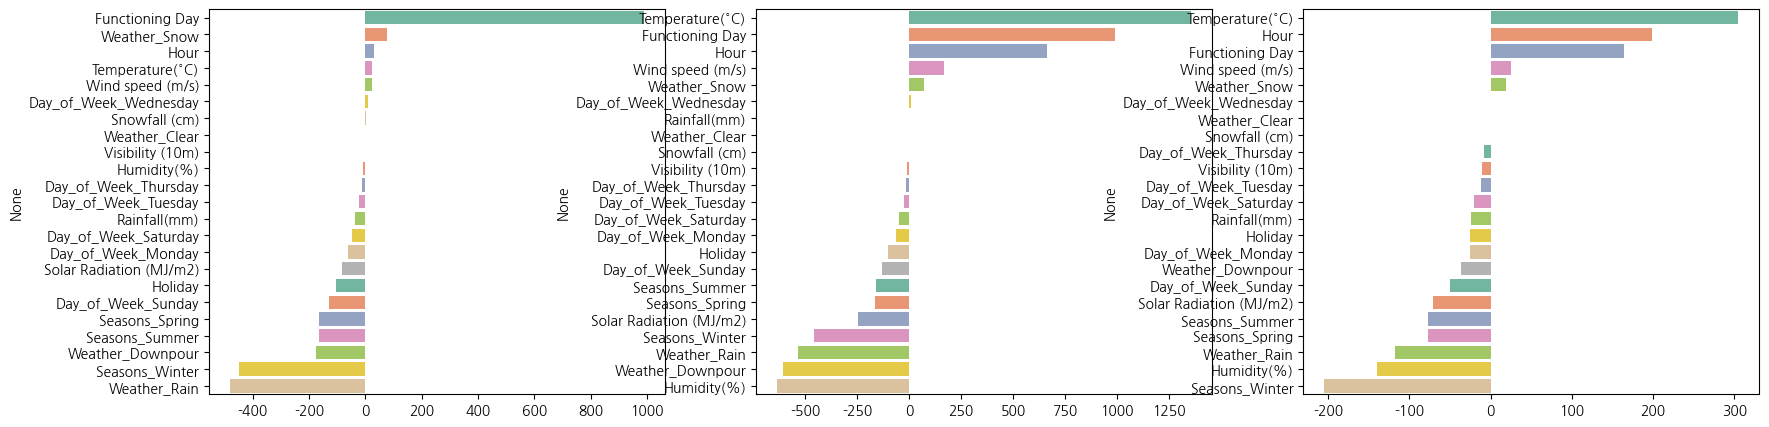

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

scalers = {'none': (X_train, X_val), 'MinMax Scaler': (X_train_mms, X_val_mms), 'Standard Scaler': (X_train_sds, X_val_sds)}

for i, (scaler_name, (X_train_scaled, X_val_scaled)) in enumerate(scalers.items(), start=1):
    print('\n' + scaler_name)
    y_pred = model.fit(X_train_scaled, y_train).predict(X_val_scaled)
    eval(y_val, y_pred)

    coef = pd.Series(model.coef_, index=X_train.columns)
    coef = coef.sort_values(ascending=False)
    sns.barplot(x=coef.values, y=coef.index, palette='Set2',ax=axes[i-1])

plt.show()

#MAE와 RMSE를 모두 고려했을 때, MinMax sclaer의 성능이 가장 우수
model.fit(X_train_mms,y_train)
y_pred = model.predict(X_val_mms)

### PCA (model2)
앞서 고려했던 수치형 변수들 중 상관계수가 높았던 Visibility (10m), Solar Radiation (MJ/m2), Humidity(%)를 하나의 차원으로 축소 

설명되는 분산비율:  [0.99919571]
주성분의 계수:  [[-9.99831582e-01 -2.09931402e-04  1.83511290e-02]]

설명되는 분산비율:  [0.59565767 0.28639294]
주성분의 계수:  [[ 0.55292888  0.49379917 -0.67114233]
 [-0.6415729   0.76625351  0.03521036]]


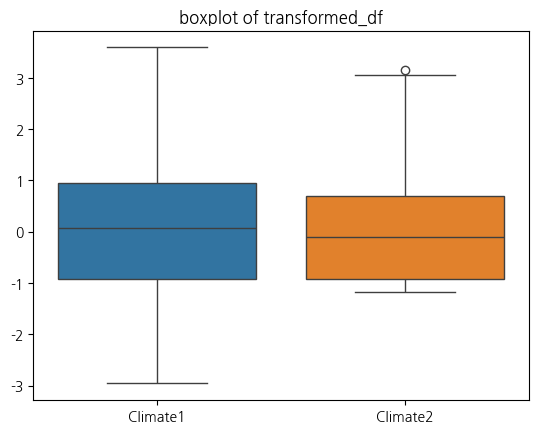

In [44]:
from sklearn.decomposition import PCA

df_PCA = X_train[['Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Humidity(%)']]

pca_model = PCA(n_components=1,random_state=1004)
pca_model.fit(df_PCA)

print('설명되는 분산비율: ',pca_model.explained_variance_ratio_) #설명되는 분산비율을 봤을 때 1개의 차원으로 충분히 설명가능
print('주성분의 계수: ' ,pca_model.components_) # 가시거리만 비중이 큼. 스케일링 필요

###################################

df_PCA = sds.fit_transform(X_train[['Visibility (10m)','Solar Radiation (MJ/m2)', 'Humidity(%)']])

pca_model = PCA(n_components=2, random_state=1004)
pca_model.fit(df_PCA)

print('\n설명되는 분산비율: ',pca_model.explained_variance_ratio_) #설명되는 분산비율을 봤을 때 2개의 차원으로 축소해야 할듯
print('주성분의 계수: ' ,pca_model.components_) 

transformed_df = pd.DataFrame(pca_model.transform(df_PCA),columns=['Climate1','Climate2'])#기후라는 의미의 Climate라고 명명
sns.boxplot(transformed_df)
plt.title('boxplot of transformed_df')
plt.show()

In [45]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

X_train_pca = pd.concat([X_train,transformed_df],axis=1)
X_train_pca.drop(['Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Humidity(%)'],axis=1,inplace=True)
display(X_train_pca.head())

tmp = pd.DataFrame(pca_model.transform(X_val[['Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Humidity(%)']]),columns=['Climate1','Climate2'])
X_val_pca = pd.concat([X_val,tmp],axis=1)
X_val_pca.drop(['Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Humidity(%)'],axis=1,inplace=True)

,Hour,Temperature(°C),Wind speed (m/s),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Spring,Seasons_Summer,Seasons_Winter,...,Weather_Rain,Weather_Snow,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Climate1,Climate2
0,8,-8.1,1.6,0.0,0.0,0,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897294,-1.110277
1,20,-0.8,2.9,0.0,1.0,0,1,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.786721,0.202133
2,1,8.9,2.1,0.0,0.0,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.097470,-0.525526
3,9,16.0,1.9,0.0,0.0,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.197764,0.643106
4,21,23.5,4.6,1.5,0.0,0,1,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-2.640478,0.864576


#### 성능검정

In [46]:
mms = MinMaxScaler()
X_train_pca_mms = mms.fit_transform(X_train_pca)
X_val_pca_mms = mms.transform(X_val_pca)

model2 = Lasso(alpha=0.5,random_state=1004)
model2.fit(X_train_pca_mms,y_train)
y_pred2 = model2.predict(X_val_pca_mms)
eval(y_val,y_pred2) #띠용쓰.. 폐기
y_pred2

MAE : 76418.214, RMSE : 83176.820
Variance score : -16433.514


array([102790.16772612, 105881.81038235, 108486.62000859, ...,
        61584.61328167,  35429.19803472, 101118.61238536])

### 변수 재선별 (model3)
현재까지 가장 성능이 좋았던 alpha=0.5, MinMax Scaler를 적용한 모델의 회귀계수를 보고 변수 선별

In [47]:
print(pd.Series(np.round(model.coef_,1),index=X_train.columns).abs().sort_values())

#Weather_Snow까지 삭제 진행
drop_index = pd.Series(np.round(model.coef_,1),index=X_train.columns).abs().sort_values().loc[:'Weather_Snow'].index
drop_index

Rainfall(mm)                  0.0
Snowfall (cm)                 0.0
Weather_Clear                 0.0
Day_of_Week_Wednesday         9.0
Visibility (10m)             10.6
Day_of_Week_Thursday         12.8
Day_of_Week_Tuesday          22.6
Day_of_Week_Saturday         47.0
Day_of_Week_Monday           61.3
Weather_Snow                 71.7
Holiday                     100.6
Day_of_Week_Sunday          130.9
Seasons_Summer              157.6
Seasons_Spring              161.8
Wind speed (m/s)            167.9
Solar Radiation (MJ/m2)     247.6
Seasons_Winter              457.8
Weather_Rain                537.0
Weather_Downpour            606.6
Humidity(%)                 636.6
Hour                        664.1
Functioning Day             989.2
Temperature(°C)            1357.5
dtype: float64


Index(['Rainfall(mm)', 'Snowfall (cm)', 'Weather_Clear',
       'Day_of_Week_Wednesday', 'Visibility (10m)', 'Day_of_Week_Thursday',
       'Day_of_Week_Tuesday', 'Day_of_Week_Saturday', 'Day_of_Week_Monday',
       'Weather_Snow'],
      dtype='object')

In [48]:
X_train2 = X_train.drop(drop_index,axis=1)
X_val2 = X_val.drop(drop_index,axis=1)

#스케일링
mms2 = MinMaxScaler()
X_train2_mms = mms2.fit_transform(X_train2)
X_val2_mms = mms2.transform(X_val2)

#### 성능검정

MAE : 314.091, RMSE : 412.084
Variance score : 0.597
model3의 회귀계수: 
 [ 666.6 1332.8 -601.8  174.8 -235.5 -101.   977.4 -159.  -152.3 -446.
 -616.6 -545.  -110.4]


<Axes: ylabel='None'>

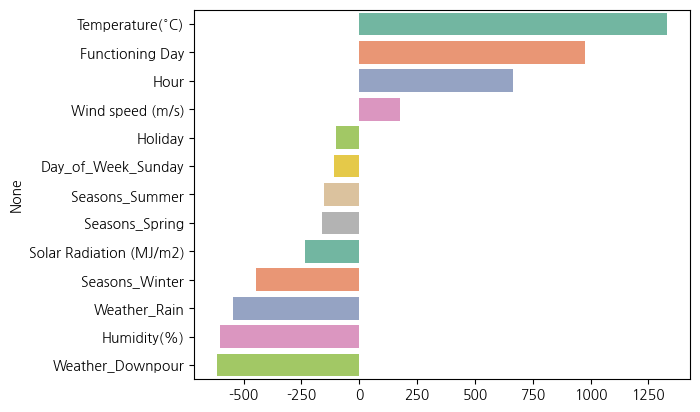

In [49]:
model3 = Lasso(alpha=0.5,random_state=1004)
model3.fit(X_train2_mms,y_train)
y_pred3 = model3.predict(X_val2_mms)
eval(y_val,y_pred3)
#소폭 상향
print('model3의 회귀계수: \n',np.round(model3.coef_,1))

coef = pd.Series(model3.coef_, index=X_train2.columns)
coef = coef.sort_values(ascending=False)
sns.barplot(x=coef.values, y=coef.index, palette='Set2')

<Axes: >

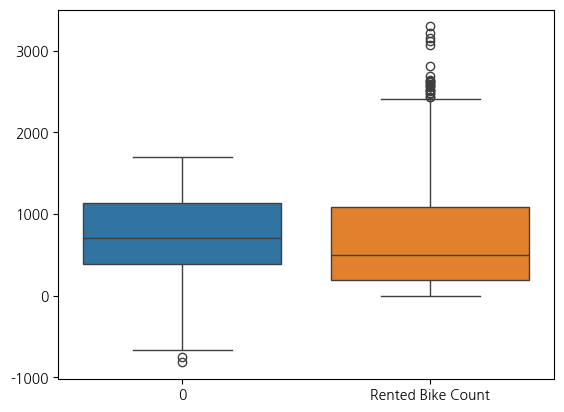

In [50]:
sns.boxplot([y_pred3,y_val])

### 종속변수 로그변환 (model4)

<Axes: xlabel='Rented Bike Count', ylabel='Count'>

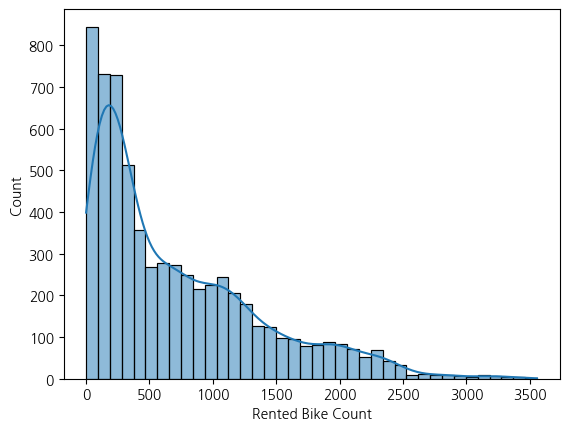

In [51]:
sns.histplot(y_train, kde=True) #왼쪽으로 치우친상태

<Axes: xlabel='Rented Bike Count', ylabel='Count'>

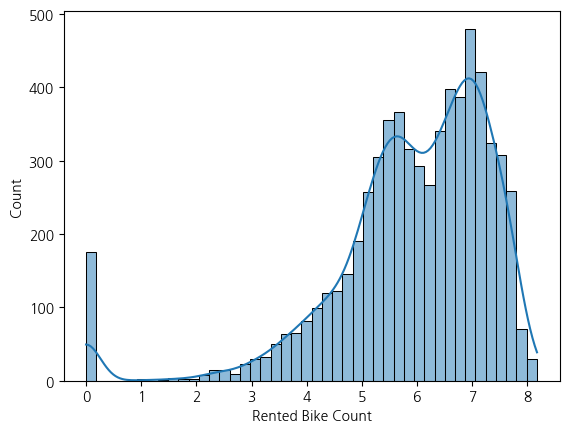

In [52]:
y_train_log = np.log1p(y_train)

sns.histplot(y_train_log, kde=True) #오히려 우측으로 치우친것 같기도하고.. 0 빼면 균형이 맞는 것 같기도하고..

#### 성능검정

In [53]:
model4 = Lasso(alpha=0.5,random_state=1004)
model4.fit(X_train2_mms, y_train_log)
y_pred4 = model4.predict(X_val2_mms)
y_pred4 = np.expm1(y_pred4)
eval(y_val,y_pred4) #얼라리..? 왤케 쓰레기지

print(y_pred4)
model.coef_ #이유는 모르겠어요...

MAE : 517.362, RMSE : 734.599
Variance score : -0.282
[367.40246271 367.40246271 367.40246271 ... 367.40246271 367.40246271
 367.40246271]


array([ 664.12647541, 1357.453361  , -636.60589304,  167.86178114,
        -10.58159127, -247.57932543,   -0.        ,    0.        ,
       -100.61128438,  989.16000143, -161.76123384, -157.57537506,
       -457.84385063,    0.        , -606.55135916, -537.01277104,
         71.73344987,  -61.27716983,  -46.95118525, -130.94252913,
        -12.8064413 ,  -22.63793399,    9.03130956])

## 모델 확정

### best 모델
가장 성능이 좋았던 MinMax Scaler를 적용한(mms2) model3으로 test_target값 생성(Lasso, alpha =0.5, X_train2_mms피팅, 종속변수 로그변환 x)

<Axes: >

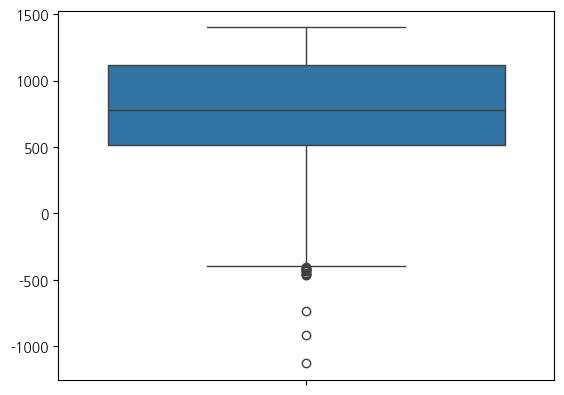

In [54]:
test_mms = mms2.transform(test[X_train2.columns])

Target_lasso = model3.predict(test_mms)
sns.boxplot(Target_lasso) #지나치게 큰 음수가 존재하고 결과가 좋지 않아보임.

### 다른 회귀 모델
제대로 공부한 모델이 선형회귀뿐이라 선형회귀를 이용했지만,
<br> 연속형 변수보다 이산형변수, 특히 이분변수가 많아 성능이 떨어지는 것으로 생각됨.
<br> -> 전반적으로 성능이 좋은 앙상블 회귀모델을 다양하게 돌려보고 선택할 모델을 심도있게 공부

In [55]:
#모델 별로 학습, 예측, 평가를 시행할 수 있는 함수 생성
def get_model_predict(model, X_train, X_val, y_train, y_val, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    if is_expm1 : #종속변수 로그변환도 고려할 수 있도록 if문으로 하나 추가
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    eval(y_val, pred)

In [56]:
#우선 위에서 시험 삼아 해봤던 모델 돌려보기
lr = LinearRegression()
ridge = Ridge(alpha=3)
lasso = Lasso(alpha=0.5)

for model in [lr, ridge, lasso]:
    get_model_predict(model,X_train, X_val, y_train, y_val,is_expm1=False)

### LinearRegression ###
MAE : 315.018, RMSE : 413.100
Variance score : 0.595
### Ridge ###
MAE : 314.766, RMSE : 412.952
Variance score : 0.595
### Lasso ###
MAE : 314.480, RMSE : 412.633
Variance score : 0.596


In [57]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf = RandomForestRegressor()
gbm = GradientBoostingRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()

for model in [rf, gbm, xgb, lgbm]:
    get_model_predict(model,X_train, X_val, y_train, y_val,is_expm1=False)

print('\n종속변수 로그변환')
for model in [rf, gbm, xgb, lgbm]:
    get_model_predict(model,X_train, X_val, y_train_log, y_val,is_expm1=True)

### RandomForestRegressor ###
MAE : 109.437, RMSE : 187.763
Variance score : 0.916
### GradientBoostingRegressor ###
MAE : 170.641, RMSE : 252.377
Variance score : 0.849
### XGBRegressor ###
MAE : 108.626, RMSE : 175.927
Variance score : 0.926
### LGBMRegressor ###
MAE : 105.262, RMSE : 172.756
Variance score : 0.929

종속변수 로그변환
### RandomForestRegressor ###
MAE : 107.720, RMSE : 192.364
Variance score : 0.912
### GradientBoostingRegressor ###
MAE : 162.640, RMSE : 267.054
Variance score : 0.831
### XGBRegressor ###
MAE : 102.457, RMSE : 182.342
Variance score : 0.921
### LGBMRegressor ###
MAE : 107.596, RMSE : 188.931
Variance score : 0.915


### 최종 모델 선정
- 전부 선형회귀에 비해 성능이 매우 뛰어남. 
- 그 중 lighgGBM 모델의 성능이 가장 좋음.
- 변수 선택이나 하이퍼파라미터 튜닝을 통해 성능을 더욱 향상시킬 수 있겠지만, 과적합을 고려했을 때 충분히 좋은 성능을 보인다고 생각함.

#### lightGBM
 - XGboost의 학습시간, 메모리사용량 등의 단점을 보완한 모델
 - 카테고리형 피처의 자동 변환해 원-핫인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드분할 수행이 가능
 - 일반적인 균형트리분할 방식 대신 리프 중심의 트리분할 방식을 사용함. 최대 손실값(max data loss)을 갖는 leaf node를 지속적으로 분할.
 - 과적합에 취약해 일반적으로 10000개 이상의 데이터를 필요로 함.
 

#### 예측완료 데이터셋 생성

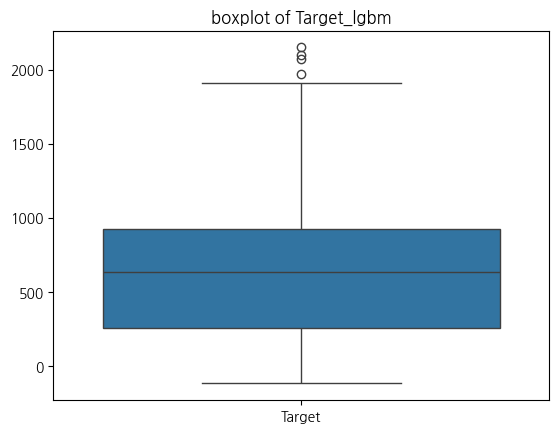

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Target
0,01/11/2018,0,5.7,62,2.3,1909,-1.0,0.0,0.0,0.0,Autumn,No Holiday,Yes,417.678064
1,01/11/2018,1,5.1,65,1.6,1932,-0.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,363.117112
2,01/11/2018,2,4.4,64,NaN,2000,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,268.524407
3,01/11/2018,3,4.2,65,0.7,1962,-1.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,196.687885
4,01/11/2018,4,3.6,70,0.8,1934,-1.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,150.409405


In [58]:
lgbm = LGBMRegressor(n_estimators=100)
lgbm.fit(X_train, y_train)
Target_lgbm = pd.DataFrame(lgbm.predict(test),columns=['Target'])
test_예측완료 = pd.concat([test_origin, Target_lgbm],axis=1)

sns.boxplot(Target_lgbm)
plt.title('boxplot of Target_lgbm')
plt.show()

test_예측완료.head()

In [59]:
test_예측완료.to_csv('./data/test_예측완료.csv', index = False)

## 아쉬운점
- 초기 모델을 정할 때 이미 공부해봤다는 이유만으로 선형회귀모델을 선정한 것이 아쉬움(나름 성능향상에 많은 시간을 썼지만, 좀처럼 되지 않아 지쳐버림)
- 성능이 좋은 모델들을 돌려봤을 때 성능이 매우 좋게 나온 것으로 보아, 결측치 처리 등 전처리를 잘했다고 생각함
+ 뒤늦게 새로운 모델을 적용해보면서 모델에 대해 자세히 공부할 수 있는 시간을 확보하지 못함. (하이퍼파라미터 튜닝을 제대로 시도하지 못함)
+ 개인적으로 모델 공부를 열심히해 다른 데이터셋을 접했을 때 그에 맞는 모델을 떠올릴 수 있도록 하겠음.
- 과적합을 이야기할 때 지표나 그래프를 보고 판단한 것이 아니라는 점이 아쉬움 
<br>0.94정도의 R2 스코어도 충분히 과적합이라고 볼 수 있을 만한 스코어 인듯하지만, 0.88~0.94 정도의 스코어 어떤 것을 선택해야하는지 공부가 필요할듯함.